**TME2 FAURE Guillaume et LUCAS Garance**

In [14]:
#!pip install -U --user dice-ml
#!pip install torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl (102.6 MB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl (54.6 MB)
  Using cached filelock-3.12.4-py3-none-any.whl (11 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_nvtx_cu11-11.7.91-py3-none-manylinux1_x86_64.whl (98 kB)
  Using cached nvidia_cufft_cu11-10.9

**Import**

In [1]:
import numpy as np
import math as m
import sklearn as sk
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy as cp
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import dice_ml 
from dice_ml.utils import helpers
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

/home/pidoux/.local/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


**half moons**

In [2]:
X,y = make_moons(n_samples=2000, shuffle=True, noise =0.05)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1000, train_size=1000, shuffle=True)

datset = np.hstack((X_train, y_train.reshape(-1,1)))

In [13]:
train_dataset = pd.DataFrame(datset, columns= ["x0", "x1","outcome"])
print(train_dataset)
test_dataset = pd.DataFrame(X_test, columns= ["x0", "x1"])
print(test_dataset)

           x0        x1  outcome
0   -0.696144  0.618090      0.0
1    0.785500 -0.499431      1.0
2    1.658642 -0.312581      1.0
3    0.975250  0.165091      0.0
4   -0.353239  0.844901      0.0
..        ...       ...      ...
995 -0.219282  0.974710      0.0
996  0.284510 -0.182346      1.0
997  0.547942  0.706185      0.0
998  1.269184 -0.428727      1.0
999  0.275358  0.847617      0.0

[1000 rows x 3 columns]
           x0        x1
0    0.562921  0.784793
1    1.557688 -0.282358
2    0.800345 -0.489655
3    1.427040 -0.384083
4    0.038535  0.075847
..        ...       ...
995  0.976037  0.339880
996  1.673701 -0.270422
997  1.769046 -0.097648
998  0.911872 -0.541168
999  0.818051  0.569417

[1000 rows x 2 columns]


Époque [100/1000], Perte: 0.39442873001098633
Époque [200/1000], Perte: 0.3310006856918335
Époque [300/1000], Perte: 0.30175259709358215
Époque [400/1000], Perte: 0.28399455547332764
Époque [500/1000], Perte: 0.2719191908836365
Époque [600/1000], Perte: 0.2632176876068115
Époque [700/1000], Perte: 0.2567184865474701
Époque [800/1000], Perte: 0.2517377436161041
Époque [900/1000], Perte: 0.24784250557422638
Époque [1000/1000], Perte: 0.24474450945854187


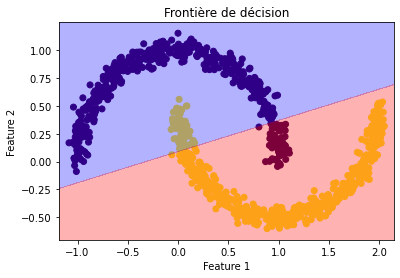

In [18]:
# Convertir les données en tenseurs PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

# Créer un modèle de régression logistique simple
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = 2
model = LogisticRegressionModel(input_dim)

# Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Entraîner le modèle
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Époque [{epoch+1}/{num_epochs}], Perte: {loss.item()}')

# Évaluer le modèle sur des données de test
X_test_t = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    predicted = model(X_test_t)
    predicted_class = (predicted >= 0.5).float()


# Tracer la frontière de décision
plt.scatter(X_train_t[:, 0], X_train_t[:, 1], c=y_train_t)
x_min, x_max = X_train_t[:, 0].min() - 0.1, X_train_t[:, 0].max() + 0.1
y_min, y_max = X_train_t[:, 1].min() - 0.1, X_train_t[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z.detach().numpy(), levels=[0, 0.5, 1], colors=['blue', 'red'], alpha=0.3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Frontière de décision')
plt.show()

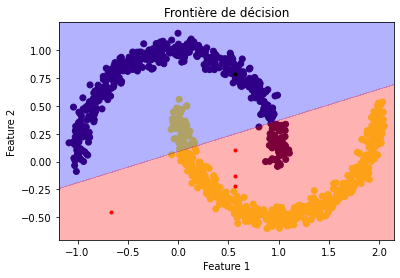

In [37]:
# Tracer la frontière de décision
plt.scatter(X_train_t[:, 0], X_train_t[:, 1], c=y_train_t)
x_min, x_max = X_train_t[:, 0].min() - 0.1, X_train_t[:, 0].max() + 0.1
y_min, y_max = X_train_t[:, 1].min() - 0.1, X_train_t[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z.detach().numpy(), levels=[0, 0.5, 1], colors=['blue', 'red'], alpha=0.3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Frontière de décision')
plt.plot(X_test_t[0, 0], X_test_t[0, 1], 'k.')
plt.plot(m[:, 0], m[:, 1], 'r.')
plt.show()

In [21]:
data = dice_ml.Data(dataframe=train_dataset, continuous_features=['x0','x1'], outcome_name='outcome')
m = dice_ml.Model(model=model, backend="PYT")


In [22]:
exp = dice_ml.Dice(data,m)

In [28]:
# Generate counterfactual examples
query_instance = test_dataset[0:1]
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
d = dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

Query instance (original outcome : 0)


,x0,x1,outcome
0,0.562921,0.784793,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,0.562921,0.101114,1
1,0.562921,-0.131372,1
2,0.562921,-0.218368,1
3,-0.663211,-0.450402,1


In [34]:
# Tracer la frontière de décision
plt.scatter(X_train_t[:, 0], X_train_t[:, 1], c=y_train_t)
x_min, x_max = X_train_t[:, 0].min() - 0.1, X_train_t[:, 0].max() + 0.1
y_min, y_max = X_train_t[:, 1].min() - 0.1, X_train_t[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z.detach().numpy(), levels=[0, 0.5, 1], colors=['blue', 'red'], alpha=0.3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Frontière de décision')
plt.plot(X_test_t[0, 0], X_test_t[0, 1], 'k.')
plt.plot(dice_exp[], dice_exp['x2'] 'r.')
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4139362558.py, line 13)

In [35]:
m = dice_exp.cf_examples_list[0].final_cfs_df.to_numpy()

In [5]:
#%pip install tensorflow
import tensorflow as tf

2023-09-26 16:41:31.623969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 16:41:31.667897: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 16:41:31.668507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 16:41:32.518555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
dataset =helpers.load_adult_income_dataset()
target = dataset['income']
train_dataset, test_dataset, _, _ = train_test_split(dataset, target, test_size=0.2, random_state=0,stratify=target)

# initialise DiCE
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age','hours_per_week'], outcome_name='income') 

m= dice_ml.Model(model_path=dice_ml.utils.helpers.get_adult_income_modelpath(), backend='TF2',func ="ohe-min-max")
exp = dice_ml.Dice(d,m)




2023-09-26 16:42:07.484795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 16:42:07.609394: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
# Generate counterfactual examples
query_instance = test_dataset.drop(columns="income")[0:1]
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()